<a href="https://colab.research.google.com/github/simulate111/Basics-of-Programming---Exercise/blob/main/Copy_of_My_first_neural_network-complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **My first neural network**

This notebook is adapted from Aurelion Geron's "Neural nets in Keras" notebook (section "Building an Image Classifier"). You can find all of his notebooks from [here](https://github.com/ageron/handson-ml2). You can find more details in the [TF Sequential model guide](https://www.tensorflow.org/guide/keras/sequential_model) (it uses a convolutional net as the model, but the text should be mostly understandable anyway).

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

We first import a few common modules and ensure MatplotLib plots figures inline.

In [1]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Import TensorFlow and Keras.

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras
# Just comment these off if you don't want to see them
print("TF:    ", tf.__version__)
print("Keras: ", keras.__version__)

TF:     2.15.0
Keras:  2.15.0


In [3]:
#!pip install scikeras[tensorflow]
#from scikeras.wrappers import KerasRegressor
#keras_reg = KerasRegressor(build_model)

Initialize random number generators. In this way we get same results on different runs of the notebook.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Loading the Fashion MNIST dataset

Keras has a few [datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) readily available, and loading them is very easy. These datasets are reasonably small so we can just load them in numpy vectors. For the one we are using - Fashion MNIST - see its [`load_data`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) documentation for more information about this dataset.

Fashion MNIST dataset is already split to a training set and a test set. We'll split the full training set further to an actual training set and a validation set (hence the choice of names below).

In [5]:
#fashion_mnist = keras.datasets.fashion_mnist
fashion_mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Let's see what the training data is made of. Recall that tensors are just grid-like arrangements of elements. `shape` tells the form of that grid and `dtype` the type of elements.

In [6]:
print('Training data shape:', X_train_full.shape)
print('Training data dtype:', X_train_full.dtype)

Training data shape: (60000, 28, 28)
Training data dtype: uint8


Each pixel intensity is represented as a byte (unsigned 8-bit integer), hence the value range is from 0 to 255.

How about the labels?

In [7]:
print('Training label shape:', y_train_full.shape)
print('Training label dtype:', y_train_full.dtype)

Training label shape: (60000,)
Training label dtype: uint8


The labels are the class IDs (represented as uint8), from 0 to 9:

In [8]:
print(y_train_full)

[5 0 4 ... 5 6 8]


Here are the corresponding class names:

In [9]:
#As I replaced Just replace the line (fashion_mnist = keras.datasets.fashion_mnist) with (fashion_mnist = keras.datasets.mnist)
#(Of course, the list class_names makes now no sense).
class_names = ["T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

We can no decode the class names of examples.

In [10]:
print('Class of the first image is "', class_names[y_train_full[0]], '"')

Class of the first image is " Sandal "


We next split the full training set into a validation set (first 5000 examples) and the actual training set (from 5000 upwards). A similar split is done for the target values.

We also scale all pixel intensities down to the 0-1 range and convert them to floats, simply by dividing them by (floating point) 255.

In [11]:
X_valid, X_train = 2*X_train_full[:5000] / 255.-1, 2*X_train_full[5000:] / 255.-1

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# remember to scale all data in a similar way
X_test = 2*X_test / 255.-1

Let's verify that our datasets are as intended.

In [12]:
print('Training data shape  :', X_train.shape)
print('Validation data shape:', X_valid.shape)
print('Test data shape      :', X_test.shape)

Training data shape  : (55000, 28, 28)
Validation data shape: (5000, 28, 28)
Test data shape      : (10000, 28, 28)


You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map. Note that we do this after scaling the pixels to 0-1 floats.

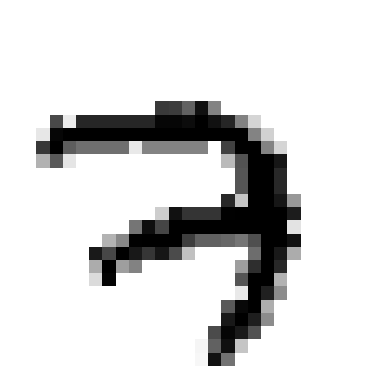

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Let's take a look at a larger sample of images (we also label them with their class names).

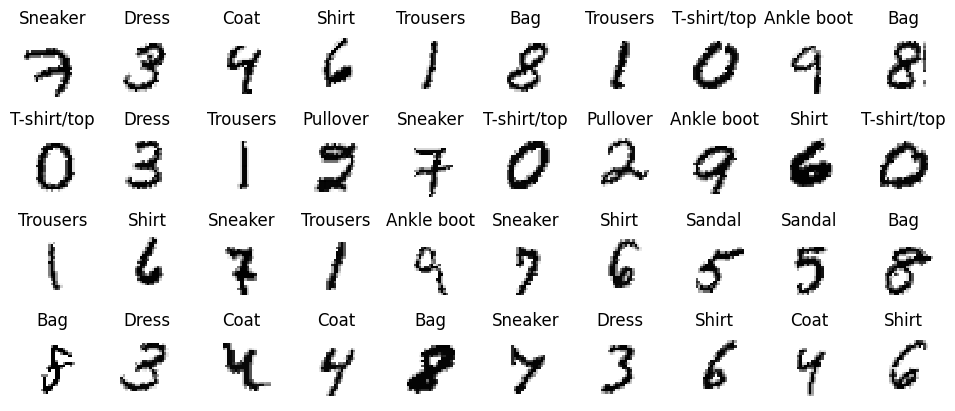

In [14]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# Creating the model

We build a MLP with two hidden layers using the Keras [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Sequential models offer a very easy way of building neural networks that are composed of a single stack of layers connected sequentially (like MLPs). We just add them on top of each other using the `add` operation.

In [15]:
model = keras.models.Sequential()

Recall that MLPs want their inputs as vectors. And our data consists of small matrices.

The first layer is an utility layer that converts (flattens) the pixel matrices to vectors (of 28*28 = 784 elements). You could do the same with Numpy [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)(and then use the resulting vector as the input).

In [16]:
model.add(keras.layers.Flatten(input_shape = (28, 28)))

We also specified the input shape for the first layer appearing in the network.Note that the shape does _not_ include the minibatch size, just the shape of the data elements. Keras needs to know this shape before it can (automatically) build weight matrix and bias vector between the input and first hidden layer.

Specifying the input shape is not strictly necessary: Keras will build the weight matrix when the model is first trained with actual data (the input shape is evident from the trainig data).

*Best practise*: specify the input shape of a Sequential model if you know what it is. In this way you can print model summaries immediately after adding layers.

In [17]:
# It's also a good practise to present numbers as products of the things they are made of
# So instead of 784 (nobody knows where it came from), use 28*28
print(28*28)

784


Next we add two (fully connected) hidden layers and specify their sizes and activation functions.

Fully connected layers are called [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers. Each Dense layer has its own weight matrix and bias vector.

If you don't give an activation, it defaults to "no activation" (i.e. the output is what weight matrix*input vector + bias gives).

**Note.**
Many Keras operations can be accessed using a "string name". For example, specifying `activation="relu"` is equivalent to specifying `activation=keras.activations.relu`. In practise this means that the corresponding operation will be used with its default parameter values. You find lots and lots of tutorials using this string naming.

*Best practise:* Always use the actual classes and operations, not their string names. Everyone sees then from which library the operation comes from, and you can give your own parameter values instead of the default ones. If you want to make the names shorter, just introduce your own aliases.

In [18]:
model.add(keras.layers.Dense(300, activation = keras.activations.relu))

# use your own naming
my_activation = keras.activations.relu
model.add(keras.layers.Dense(100, activation = my_activation))

In [19]:
# same using the string names
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))

We end the model with an output layer of size 10 (since we had 10 classes) and [`softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) activation (since we have a multiclass problem).


In [20]:
model.add(keras.layers.Dense(10, activation = keras.activations.softmax))

# model.add(keras.layers.Dense(10, activation = "softmax"))

The Sequential model initializer accepts a list of model layers, so we can build our model also in the way below. This is a more flexible way and allows you to build such layer lists in your code before creating a model.

In [21]:
# This is useful when you create and throw away lots of models (consumes memory)
# See https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session

def free_memory():
  keras.backend.clear_session()

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(300, activation = keras.activations.relu),
    keras.layers.Dense(100, activation = keras.activations.relu),
    keras.layers.Dense(10,  activation = keras.activations.softmax)
])

You can also make a routine that returns models. In this way you can easily create new fresh untrained models when needed.

In [23]:
def create_MLP():
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(300, activation = keras.activations.relu),
    keras.layers.Dense(100, activation = keras.activations.relu),
    keras.layers.Dense(10,  activation = keras.activations.softmax)
  ])
  return model

In [24]:
free_memory()
model = create_MLP()

# Examining models

The usual way to examine a (possibly partially) built model is its `summary()`.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The first axis is (always) the "batch axis". Value `None` tells that it has not been specified (this is ok and allows you to use different minibatch sizes with the same model).

*Best practise:*  When building a new model, print model summaries every now and then after adding new layers.


There is also a utility `plot_model` to get a graphical representation of a model. In more complex architectures, this is helpful to get a grasp on how different parts of the model are connected to each other. Since MLP is just a stack, the graphics don't really add anything new to the summary.

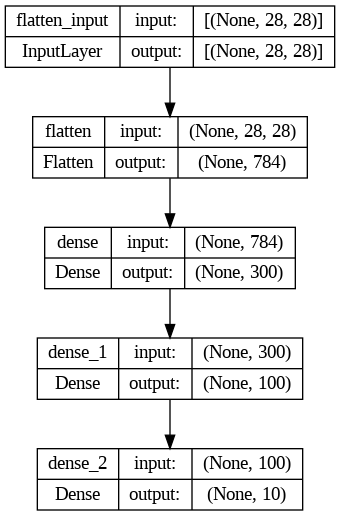

In [26]:
keras.utils.plot_model(model, show_shapes=True)

## Sidestep: Examining layers

You might need to access the layers directly in some applications. The layers are stored as a list in `model.layers`. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer for all details.

In [27]:
type(model.layers)

list

In [28]:
print(*model.layers, sep='\n')

All layers have also a name (string). You can specify your own names when creating a layers. If you don't, Keras uses its own internal naming scheme (as seen in the summary).

In [29]:
hidden1 = model.layers[1]
print(hidden1.name)

dense


While you can access layers by their index, you can also access them by their name.

In [30]:
named_layer = model.get_layer(hidden1.name)
# test that we got the same layer as when indexing with 1
print(named_layer is hidden1)

True


You have also access to the weights and biases of layers. Operation `get_weights` returns all parameters (weights and biases in this case) of the layer in a list. This may be a bit confusing in the start.

In [31]:
h1_params = hidden1.get_weights()
print(type(h1_params))
print(len(h1_params))

<class 'list'>
2


Let's first examine the weights. Looks like they have been initialized to small random values.

In [32]:
# weights are the first element
h1_weights = h1_params[0]
print(type(h1_weights))
print('Weight matrix shape: ', h1_weights.shape, '\n')
print(h1_weights, '\n')
print('Weight at 0,0:', h1_weights[0,0])

<class 'numpy.ndarray'>
Weight matrix shape:  (784, 300) 

[[-0.01649702 -0.03793226 -0.02710285 ...  0.028433    0.02177224
  -0.0128735 ]
 [-0.05661838 -0.03159807  0.07037747 ...  0.00804456  0.04846548
  -0.0706289 ]
 [ 0.04488044  0.05382685 -0.04741816 ...  0.0742539  -0.02658099
  -0.03122657]
 ...
 [-0.02346051  0.01664311 -0.07063584 ...  0.05173653 -0.04040053
  -0.07408515]
 [ 0.00078506  0.0559682   0.0552616  ...  0.05995877 -0.04747419
   0.02073065]
 [ 0.05213702 -0.01743631  0.04251451 ... -0.00483952 -0.00976052
   0.06309019]] 

Weight at 0,0: -0.01649702


Biases, on the other hand, have been initialized to zeros (it's ok).

In [33]:
# and biases are the second one
h1_biases = h1_params[1]
print(type(h1_biases))
print('Bias vector shape: ', h1_biases.shape, '\n')
print(h1_biases, '\n')
print('Bias at 0:', h1_biases[0])

<class 'numpy.ndarray'>
Bias vector shape:  (300,) 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Bias at 0: 0.0


The values in weights and biases were initialized when the layers were created. The values seen above are the result of applying default initializers; see [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) documentation for details.

# Compiling the model

After the model has been constructed, we "compile" it. In particular, we specify
- the loss function and the optimizer to use
- list of extra metrics to compute during training and evaluation (optional but highly useful)

We use the "sparse" version of cross entropy, since our class targets are just numbers (sparse versions of the corresponding one-hot vector). More of this a bit later.

Use [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy) for binary classification models (which should end with a single sigmoid output unit).

In [34]:
# Links to API documentation
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_accuracy

# Also these have their string names but not using them
my_loss = tf.keras.losses.sparse_categorical_crossentropy
my_sgd  = optimizer=keras.optimizers.SGD()
my_acc_metric = keras.metrics.sparse_categorical_accuracy

model.compile(loss = my_loss,
              optimizer = my_sgd,
              metrics=[my_acc_metric])

# Training the model

All you need to do is call the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method. It takes as its input
- input features and the target classes
- number of epochs to train (default: 1)
- validation set (optional but strongly recommended)

While training, we get progress information
- number of instances processed
- time per epoch and mean training time per sample
- loss and accuracy (or any other extra metrics)
	on both the training set and the validation set


In [35]:
history = model.fit(X_train, y_train, epochs = 30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 14s 6ms/step - loss: 0.6845 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.3664 - val_sparse_categorical_accuracy: 0.8956
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.3054 - val_sparse_categorical_accuracy: 0.9086
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3265 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.2726 - val_sparse_categorical_accuracy: 0.9218
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2867 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.9218
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2553 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9260
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2305 - spar

## Sidestep: "sparse labels"

We used the "sparse" version of cross entropy, since we didn't "one-hot" code our class target values (they are just numbers). Keras offers `to_categorical` utility, should you want to go this way.

In [36]:
y_train_hot = keras.utils.to_categorical(y_train)
y_valid_hot = keras.utils.to_categorical(y_valid)
y_test_hot  = keras.utils.to_categorical(y_test)

In [37]:
print(y_train_hot.shape)
print(y_train_hot[0])

(55000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


If needed, you can easily map one-hot vectors to their sparse versions:

In [38]:
# converts the whole tensor, argmax is applied on the entries in the second axis (our one-hot vectors)
sparse_labels = np.argmax(y_train_hot, axis=1)

In [39]:
print(sparse_labels.shape)
print(sparse_labels[0])

(55000,)
7


You then use the one-hot coded labels as the training targets and the (standard) categorical cross entropy as the loss. Everything else is the same.

In [40]:
# we create a new fresh model for training
# otherwise fit would continue from the weights already trained by the precious rounds (try this out)
free_memory()
model = create_MLP()

In [41]:
my_loss = tf.keras.losses.CategoricalCrossentropy()
my_sgd  = optimizer=keras.optimizers.SGD()
my_acc_metric = keras.metrics.categorical_accuracy

model.compile(loss = my_loss,
              optimizer = my_sgd,
              metrics=[my_acc_metric])

In [42]:
history = model.fit(X_train, y_train_hot, epochs=30,
                    validation_data=(X_valid, y_valid_hot))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7004 - categorical_accuracy: 0.7925 - val_loss: 0.3643 - val_categorical_accuracy: 0.8950
Epoch 2/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3881 - categorical_accuracy: 0.8829 - val_loss: 0.2999 - val_categorical_accuracy: 0.9122
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3329 - categorical_accuracy: 0.8988 - val_loss: 0.2735 - val_categorical_accuracy: 0.9220
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2941 - categorical_accuracy: 0.9120 - val_loss: 0.2680 - val_categorical_accuracy: 0.9160
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2627 - categorical_accuracy: 0.9212 - val_loss: 0.2338 - val_categorical_accuracy: 0.9288
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2359 - categorical_accuracy: 0.9295 - val_loss: 0.2075 - val_categorical_accuracy:

## Sidestep: Weighting classes and examples

Sometimes there are lots of examples from some classes and less examples from some other classes. Since the (default) loss is simply the mean of all individual losses, the model may "specialize" it to fit the frequent classes.

To avoid this, you can use the `class_weight` argument when training your model. Give a larger weight to underrepresented classes and a lower weight to overrepresented classes. One possible way is to set the class weights related to the inverses of class frequencies. The loss function then multiplies the individual losses using these weights.

Your examples may also vary in their trustworthiness. For example, some labels might be given by domain experts and some by crowdsourcing. You can specify a weight for each training (and validation) instance with the `sample_weight` argument.

If both `class_weight` and `sample_weight` are given, they are multiplied in loss computations. See [`fit` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for details.

# Examining training history

The output of `fit` is a `History` object, which is very useful for analysing the training process (more of this later). In particular, `history.history` (stupid name) is a Python dictionary recording all the metrics values fit reported while training.

In [43]:
hist_params = history.params
# sometimes you continue from a previous run (so epoch numbers don't always start from 0)
hist_epochs = history.epoch
hist_data = history.history

print(hist_params)
print(hist_epochs)
print(hist_data.keys())

{'verbose': 1, 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


Below is a typical matplotlib plot of the history data (layout could be improved).

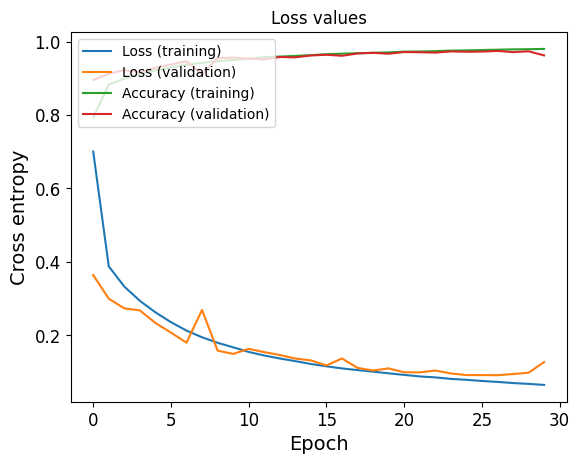

In [44]:
# select which data you want to plot (we select all of them here)
plt.plot(hist_data['loss'], label='Loss (training)')
plt.plot(hist_data['val_loss'], label='Loss (validation)')
plt.plot(hist_data['categorical_accuracy'], label='Accuracy (training)')
plt.plot(hist_data['val_categorical_accuracy'], label='Accuracy (validation)')

plt.title('Loss values')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
# You can comment this off if %matplotlib inline has been used
plt.show()

If you are familiar with Python data analysis library [`pandas`](https://pandas.pydata.org/), you can do the same in a much more compact way (and the default layout is better, too) by making use of [`DataFrame`](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe).

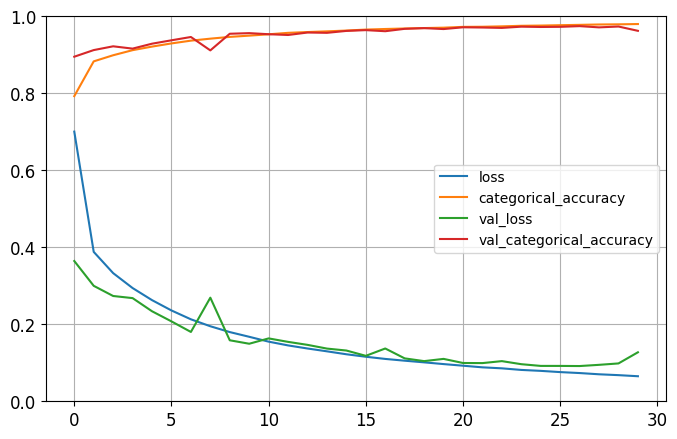

In [45]:
import pandas as pd

pd.DataFrame(hist_data).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

We see from the plots that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. The validation curves are close to the training curves, which means that there is not too much overfitting.

You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training (by calling the `fit()` method again).

It may look strange that validation accuracy is better than training accuracy in the start of the training. This is because the training accuracy is a mean of all minibatch accuracies of the epoch, while the validation accuracy (and loss) is computed at the end of the epoch. Training losses are large in the beginning since weights were just random numbers, which leads to larger mean losses.

For more comparable results, you can shift the training curve to the left by half an epoch in the plots. However, this difference should vanish after a few training epochs.

*Best practise:* plot the history curves after training. Find the "sweet spot" where validation loss/accuracy stops improving. In hyperparameter tuning, look for the best such validation accuracies. (There are automatic tools for both of these tasks)

## Few words about hyperparameter tuning

If the model isn't performing well enough, what can we tune?
- learning rate (always retune it after changing any other hyperparameter)
- another optimizer
- model hyperparameters (number of layers, neurons per layer, activation functions in hidden layers)

Real-world applications typically use a *schedule* for the learning rate. Keras offers some simple [`schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) and a customizabe [`LearningRateSchedule`](LearningRateSchedule), but you can go even more custom by defining your own "callbacks" (things that are called after each batch or epoch; more about them later).


# Evaluating the model

Our model (with best hyperparameters) has now been trained and we can evaluate it on the test set to estimate the *generalization error*.

In [46]:
#For comparision: accuracies after 30 epochs: 92.06% train, 88.56% val
# use the one you trained your model with
model.evaluate(X_test, y_test_hot)

# model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1360 - categorical_accuracy: 0.9574


[0.13604341447353363, 0.9574000239372253]

It is expected to get slightly lower performance on the test set
than on the validation set, since the hyperparameters were tuned on the validation set, not the test set.

# Using the model

We decided that the performance of our model on the test set was acceptable and we can start using it in some application to make predictions for new examples.

Since we don't have any, let's just re-use the test data.

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)


1/1 [==============================] - 0s 75ms/step


The model output consists of 10 probabilities, one for each class:

In [48]:
print(y_proba.round(2))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


It looks like the first example has class 9, second class 2 and third one class 1. We can use `argmax` to pick these indexes.

In [49]:
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

[7 2 1]


Let's see what were the corresponding ground truths (correct answers).

In [50]:
y_new = y_test[:3]
print(y_new)

[7 2 1]


Finally, we decode the class names to make them readable for humans.

In [51]:
print(np.array(class_names)[y_pred])

['Sneaker' 'Pullover' 'Trousers']


# Summary

Below is the collected code for the main steps of training a network.

In [52]:
free_memory()

In [53]:
# Load data (in this case all of it fits in the memory)
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [54]:
# Create a validation set (if needed)
# Preprocess the data (if needed, here just simple scaling)
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [55]:
# create model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(300, activation = keras.activations.relu),
    keras.layers.Dense(100, activation = keras.activations.relu),
    keras.layers.Dense(10,  activation = keras.activations.softmax)
])

In [56]:
# compile the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [57]:
# train the model
history = model.fit(X_train, y_train, epochs = 30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7331 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.5270 - val_sparse_categorical_accuracy: 0.8198
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4882 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8488
Epoch 3/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4416 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.5263 - val_sparse_categorical_accuracy: 0.8014
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.3970 - val_sparse_categorical_accuracy: 0.8630
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.3799 - val_sparse_categorical_accuracy: 0.8702
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3766 - spars